In [1]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from pmdarima.arima import ndiffs, nsdiffs 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\alexa\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [3]:
#Series stuff
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [4]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg="day")
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 00:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.638889
2016-09-06 00:00:00+00:00            0.083333
2016-09-07 00:00:00+00:00            0.500000
2016-09-08 00:00:00+00:00            0.361111
2016-09-09 00:00:00+00:00            0.000000
2016-09-10 00:00:00+00:00            0.000000
2016-09-11 00:00:00+00:00            0.027778
2016-09-12 00:00:00+00:00            0.416667
2016-09-13 00:00:00+00:00            0.277778


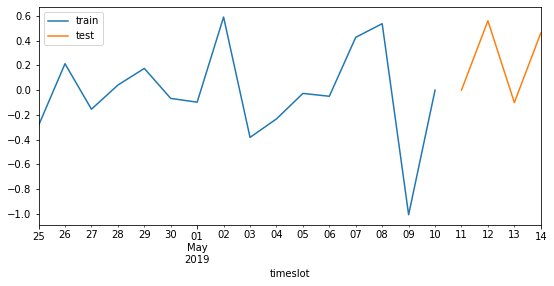

In [5]:
units_to_forecast = 4

train_series = series.diff().dropna()
train_days = 16
train = train_series[-train_days-units_to_forecast:-units_to_forecast]
test = train_series[-units_to_forecast:]


fig, ax=plt.subplots(figsize=(9, 4))
train['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
ax.legend();

In [6]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 1
                )

forecaster.fit(y=train['num_kwh_normalized'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1] 
Window size: 1 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-04-25 00:00:00+0000', tz='UTC'), Timestamp('2019-05-10 00:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-09 08:30:41 
Last fit date: 2022-06-09 08:30:41 
Skforecast version: 0.4.3 

Test error (mse): 0.0863733024903742


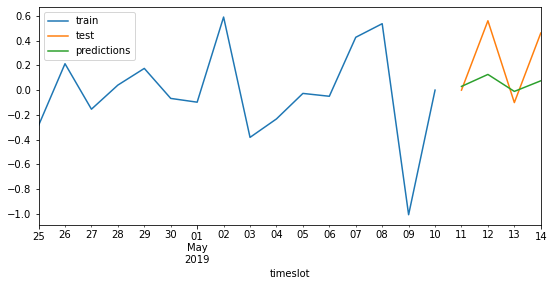

In [7]:
predictions = forecaster.predict(steps=units_to_forecast)
predictions.head(5)

fig, ax = plt.subplots(figsize=(9, 4))
train['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

error_mse = mean_squared_error(
                y_true = test['num_kwh_normalized'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

# Hyperparameter tuning

In [45]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 16 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1,2,3]

# Regressor's hyperparameters
param_grid = {'n_estimators': [i for i in range(50,100,2)],
              'max_depth': [i for i in range(3,10,1)]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_series[-train_days-units_to_forecast:]['num_kwh_normalized'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = units_to_forecast,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)),
                        return_best        = True,
                        fixed_train_size   = True,
                        verbose            = False
               )
results_grid

Number of models compared: 525


loop param_grid:  64%|█████████████████████▊            | 112/175 [00:12<00:06, 10.10it/s]


loop param_grid:  30%|██████████▍                        | 52/175 [00:05<00:13,  9.08it/s]


loop param_grid:  91%|███████████████████████████████   | 160/175 [00:17<00:01,  7.64it/s]


loop param_grid:  53%|██████████████████▌                | 93/175 [00:10<00:09,  8.27it/s]


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:59<00:00, 19.97s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 7, 'n_estimators': 50}
  Backtesting metric: 0.06187101786458326



,lags,params,metric,max_depth,n_estimators
100,[1],"{'max_depth': 7, 'n_estimators': 50}",0.061871,7,50
125,[1],"{'max_depth': 8, 'n_estimators': 50}",0.061871,8,50
150,[1],"{'max_depth': 9, 'n_estimators': 50}",0.061871,9,50
102,[1],"{'max_depth': 7, 'n_estimators': 54}",0.062353,7,54
127,[1],"{'max_depth': 8, 'n_estimators': 54}",0.062353,8,54
...,...,...,...,...,...
201,"[1, 2]","{'max_depth': 4, 'n_estimators': 52}",0.113410,4,52
326,"[1, 2]","{'max_depth': 9, 'n_estimators': 52}",0.124801,9,52
276,"[1, 2]","{'max_depth': 7, 'n_estimators': 52}",0.124801,7,52
251,"[1, 2]","{'max_depth': 6, 'n_estimators': 52}",0.124801,6,52


In [59]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[-train_days-units_to_forecast:]['num_kwh_normalized'],
                            initial_train_size = len(train),
                            steps      = units_to_forecast,
                            refit      = False,
                            interval   = [32/2, 100-32/2],
                            n_boot     = 3000,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
predictions.head(4)

1
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 16
Number of observations used for backtesting: 4
    Number of folds: 1
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2019-04-25 00:00:00+00:00 -- 2019-05-10 00:00:00+00:00
    Validation: 2019-05-11 00:00:00+00:00 -- 2019-05-14 00:00:00+00:00



,pred,lower_bound,upper_bound
2019-05-11 00:00:00+00:00,0.027466,-0.147317,0.233010
2019-05-12 00:00:00+00:00,0.130940,-0.174092,0.307483
2019-05-13 00:00:00+00:00,-0.052852,-0.167282,0.304625
2019-05-14 00:00:00+00:00,0.215094,-0.174092,0.290303


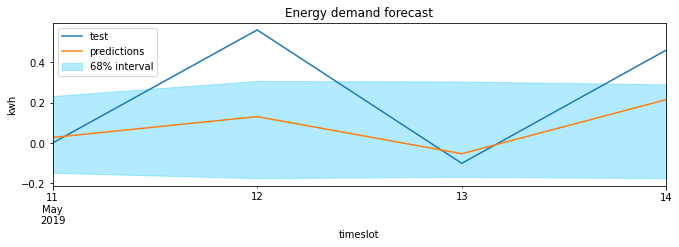

In [47]:
fig, ax=plt.subplots(figsize=(11, 3))
test['num_kwh_normalized'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '68% interval'
)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [48]:
inside_interval = np.where(
                     (train_series.loc[predictions.index, 'num_kwh_normalized'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'num_kwh_normalized'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}")

Coverage of the predicted interval on test data: 50.0


In [49]:
def undiff(diff, vals):
    result = [vals[0]]
    for i in range(len(diff)):
        result.append(vals[i]+diff[i])
    return result

def trueundiff(diff, first):
    result = [first]
    for i in range(len(diff)):
        result.append(result[-1]+diff[i])
    return result

In [50]:
truetrain = series[-train_days-units_to_forecast:-units_to_forecast]
truetest = series[-units_to_forecast:]
vals = series[-1-units_to_forecast:]['num_kwh_normalized']
truepred = undiff(np.asarray(predictions['pred']), vals)
print(truepred)

[0.0, 0.02746555555555563, 0.13094, 0.5072033333333328, 0.6745105555555553]


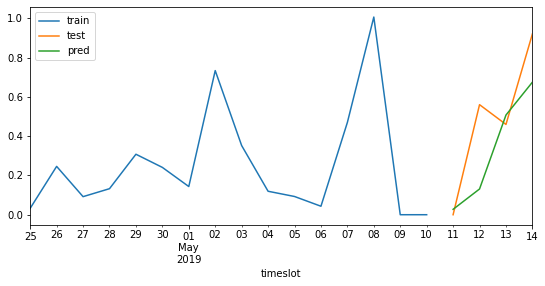

In [51]:
vals_pd = pd.DataFrame(columns = ["vals"])
vals_pd["vals"]=truepred[1:]
vals_pd.index = truetest.index

fig, ax=plt.subplots(figsize=(9, 4))
truetrain['num_kwh_normalized'].plot(ax=ax, label='train')
truetest['num_kwh_normalized'].plot(ax=ax, label='test')
vals_pd["vals"].plot(ax=ax, label='pred')
ax.legend();

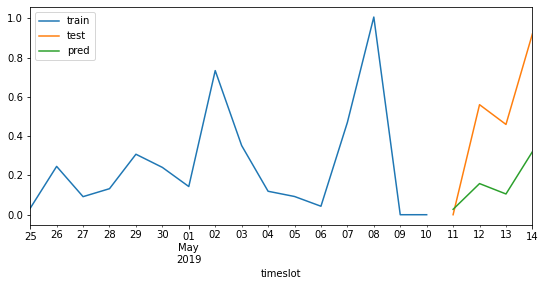

In [52]:
truepred2 = trueundiff(np.asarray(predictions['pred']), truetrain['num_kwh_normalized'][-1])
vals_pd2 = pd.DataFrame(columns = ["vals"])
vals_pd2["vals"]=truepred2[1:]
vals_pd2.index = truetest.index

fig, ax=plt.subplots(figsize=(9, 4))
truetrain['num_kwh_normalized'].plot(ax=ax, label='train')
truetest['num_kwh_normalized'].plot(ax=ax, label='test')
vals_pd2["vals"].plot(ax=ax, label='pred')
ax.legend();

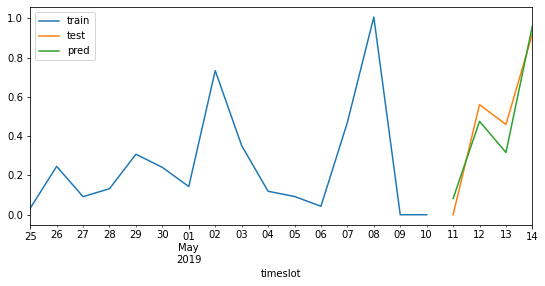

In [53]:
alpha = 3
newpred = alpha*np.asarray(truepred2[1:])
vals_pd3 = pd.DataFrame(columns = ["vals"])
vals_pd3["vals"]=newpred
vals_pd3.index = truetest.index

fig, ax=plt.subplots(figsize=(9, 4))
truetrain['num_kwh_normalized'].plot(ax=ax, label='train')
truetest['num_kwh_normalized'].plot(ax=ax, label='test')
vals_pd3["vals"].plot(ax=ax, label='pred')
ax.legend();

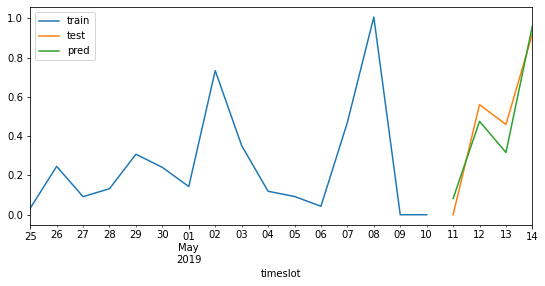

In [56]:
beta = 3
newpred2 = trueundiff(beta*np.asarray(predictions['pred']), truetrain['num_kwh_normalized'][-1])
vals_pd4 = pd.DataFrame(columns = ["vals"])
vals_pd4["vals"]=newpred2[1:]
vals_pd4.index = truetest.index

fig, ax=plt.subplots(figsize=(9, 4))
truetrain['num_kwh_normalized'].plot(ax=ax, label='train')
truetest['num_kwh_normalized'].plot(ax=ax, label='test')
vals_pd4["vals"].plot(ax=ax, label='pred')
ax.legend();

In [57]:
remainder = (len(train_series[-train_days-units_to_forecast:]['num_kwh_normalized'])-len(train))%units_to_forecast
print(remainder)

0


In [68]:
tecky = [i for i in range(0,len(train)+len(test),1)]
print(len(tecky))
print(tecky[len(train)-1:len(train)])
print(tecky[:len(train)])

20
[15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
